# Wind Energy Output Prediction- Modelling & Deployment

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_2c4b212ecf374fa692c761ecd7f72bbb = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='N2YTIh93Yfvlw61IhV1f-i_lmclF9FQpPBQCQ9xuwYPY',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_2c4b212ecf374fa692c761ecd7f72bbb.get_object(Bucket='myproject-donotdelete-pr-hzgogmf9qpe5kg',Key='Wind Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dataset = pd.read_csv(body)
dataset.head()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
#dropping Theoretical power column cause it does'nt contribute to a good prediction
dataset.drop('Theoretical_Power_Curve (KWh)',axis=1,inplace=True)
dataset.dtypes

Date/Time               object
LV ActivePower (kW)    float64
Wind Speed (m/s)       float64
Wind Direction (°)     float64
dtype: object

In [4]:
# Convert Date/Time into Datetime
dataset['Date/Time']=pd.to_datetime(dataset['Date/Time'])

In [5]:
data=dataset.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 4 columns):
Date/Time              50530 non-null datetime64[ns]
LV ActivePower (kW)    50530 non-null float64
Wind Speed (m/s)       50530 non-null float64
Wind Direction (°)     50530 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [6]:
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,265.674286


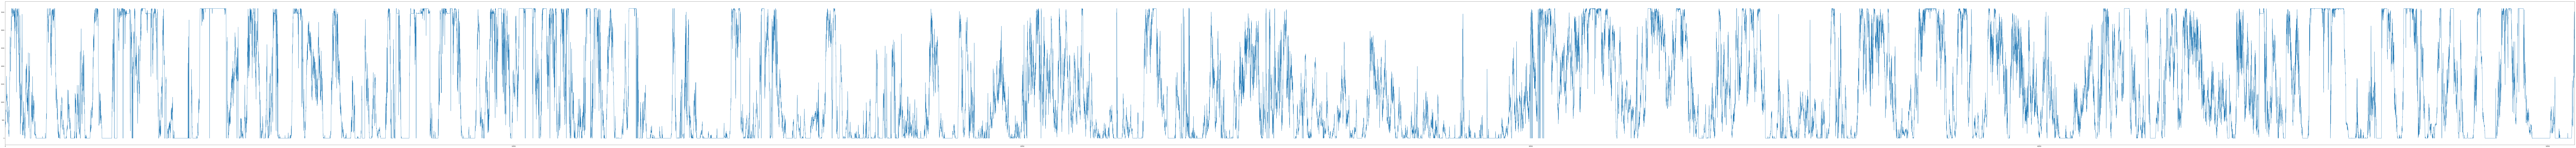

In [7]:
dataset['LV ActivePower (kW)'].plot(figsize=(350,20))

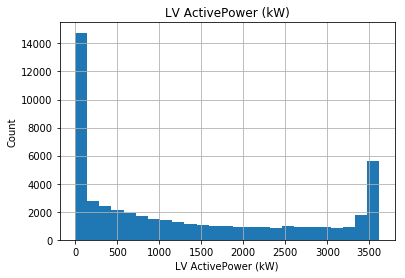

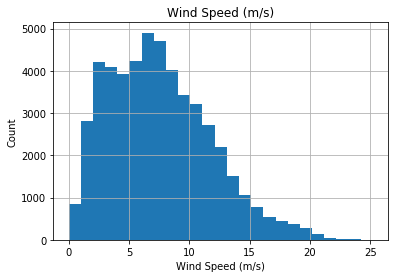

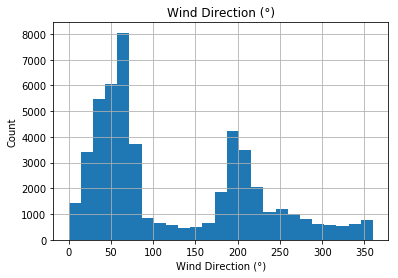

In [8]:
for feature in ['LV ActivePower (kW)','Wind Speed (m/s)','Wind Direction (°)']:
    data=dataset.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

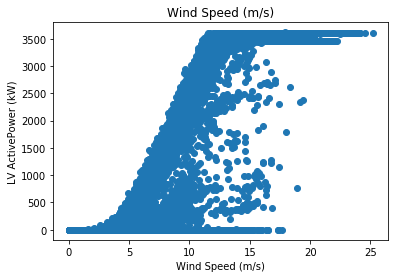

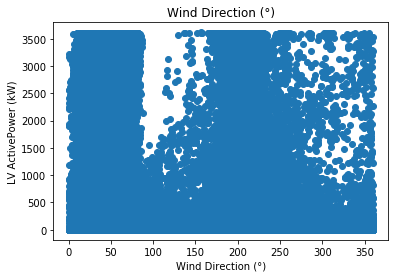

In [9]:
for feature in ['Wind Speed (m/s)','Wind Direction (°)']:
    data=dataset.copy()
    plt.scatter(data[feature],data['LV ActivePower (kW)'])
    plt.xlabel(feature)
    plt.ylabel('LV ActivePower (kW)')
    plt.title(feature)
    plt.show()

In [10]:
y=data['LV ActivePower (kW)'].values

In [11]:
data.drop('LV ActivePower (kW)',axis=1,inplace=True)
data.head()

,Date/Time,Wind Speed (m/s),Wind Direction (°)
0,2018-01-01 00:00:00,5.311336,259.994904
1,2018-01-01 00:10:00,5.672167,268.641113
2,2018-01-01 00:20:00,5.216037,272.564789
3,2018-01-01 00:30:00,5.659674,271.258087
4,2018-01-01 00:40:00,5.577941,265.674286


In [12]:
print(data.shape)
print(y.shape)

(50530, 3)
(50530,)


In [13]:
#Converting Date/Time into milliseconds
data['Date/Time']=pd.to_numeric(data['Date/Time'])

In [14]:
data.head()

,Date/Time,Wind Speed (m/s),Wind Direction (°)
0,1514764800000000000,5.311336,259.994904
1,1514765400000000000,5.672167,268.641113
2,1514766000000000000,5.216037,272.564789
3,1514766600000000000,5.659674,271.258087
4,1514767200000000000,5.577941,265.674286


In [15]:
data.dtypes

Date/Time               int64
Wind Speed (m/s)      float64
Wind Direction (°)    float64
dtype: object

In [16]:
#splitting the dataset for Training and Testing
X_train,X_test,y_train,y_test=train_test_split(data,y)

## Apllying Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
regressor=RandomForestRegressor(n_estimators=10,random_state=0)
from sklearn.model_selection import cross_val_score
regressor.fit(X_train,y_train)
train_score = cross_val_score(regressor,X_train,y_train,cv=5)
test_score = cross_val_score(regressor,X_test,y_test,cv=5)

print("train score :",np.mean(train_score))
print("test score :",np.mean(test_score))

train score : 0.9743826227444435
test score : 0.9558956801890428


## Importing Watson Machine Learning API Client

In [19]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

2020-07-15 08:57:49,430 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.


In [20]:
wml_credentials = {
  "apikey": "K8mOKDeMK8MxeeOLDyGGH97DxpudUTd_AGp60TZFLwwB",
  "iam_apikey_description": "Auto-generated for key 09f44c07-a0e8-45ae-abc4-6a40fb3db63b",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/b6dfe7663fe3412cb59ed3a1ff7168f0::serviceid:ServiceId-56a0233e-cae6-474f-8e16-cda052fc87ff",
  "instance_id": "d5cbda19-4748-4443-ae76-e89896be3af2",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

## Creating a Client with the ML Service Credentials

In [21]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [22]:
model_props = {
    client.repository.ModelMetaNames.AUTHOR_NAME : "Data Pirates",
    client.repository.ModelMetaNames.AUTHOR_EMAIL : "abhinavj65@gmail.com",
    client.repository.ModelMetaNames.NAME : "windenergyprediction"
}

In [23]:
model_artifact = client.repository.store_model(regressor,meta_props = model_props)

In [21]:
model_artifact

{'metadata': {'guid': 'f07a1833-0ada-4733-ad5d-453787ea48e7',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/published_models/f07a1833-0ada-4733-ad5d-453787ea48e7',
  'created_at': '2020-07-14T13:43:57.454Z',
  'modified_at': '2020-07-14T13:43:57.516Z'},
 'entity': {'runtime_environment': 'python-3.6',
  'learning_configuration_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/published_models/f07a1833-0ada-4733-ad5d-453787ea48e7/learning_configuration',
  'author': {'name': 'Data Pirates'},
  'name': 'windenergyprediction',
  'learning_iterations_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/published_models/f07a1833-0ada-4733-ad5d-453787ea48e7/learning_iterations',
  'feedback_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/published_models/f07a1833-0ada-4733-ad5d-453787ea48e7/feedback',
  'latest_version':

In [22]:
guid = client.repository.get_model_uid(model_artifact)
guid

'f07a1833-0ada-4733-ad5d-453787ea48e7'

## Deployment Creation

In [23]:
deploy = client.deployments.create(guid,name = "Wind_energy_pred_d")



#######################################################################################

Synchronous deployment creation for uid: 'f07a1833-0ada-4733-ad5d-453787ea48e7' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='fc2d9f37-77d6-4203-a0bc-b45bea5de623'
------------------------------------------------------------------------------------------------




In [24]:
#List of deployments
client.deployments.list()

------------------------------------  ------------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME                TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
fc2d9f37-77d6-4203-a0bc-b45bea5de623  Wind_energy_pred_d  online  DEPLOY_SUCCESS  2020-07-14T13:44:15.890Z  scikit-learn-0.20  model
ab6e725a-10f7-44b4-b2db-81e602e534ce  Life-Expectancy     online  DEPLOY_SUCCESS  2020-06-13T07:53:27.893Z  scikit-learn-0.20  model
------------------------------------  ------------------  ------  --------------  ------------------------  -----------------  -------------


In [25]:
deploy

{'metadata': {'guid': 'fc2d9f37-77d6-4203-a0bc-b45bea5de623',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/deployments/fc2d9f37-77d6-4203-a0bc-b45bea5de623',
  'created_at': '2020-07-14T13:44:15.890Z',
  'modified_at': '2020-07-14T13:44:16.128Z'},
 'entity': {'runtime_environment': 'python-3.6',
  'name': 'Wind_energy_pred_d',
  'scoring_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/deployments/fc2d9f37-77d6-4203-a0bc-b45bea5de623/online',
  'deployable_asset': {'name': 'windenergyprediction',
   'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/published_models/f07a1833-0ada-4733-ad5d-453787ea48e7',
   'guid': 'f07a1833-0ada-4733-ad5d-453787ea48e7',
   'created_at': '2020-07-14T13:44:15.867Z',
   'type': 'model'},
  'description': 'Description of deployment',
  'status_details': {'status': 'DEPLOY_SUCCESS'},
  'model_type': 'scikit-learn-0.20',
  '

## Scoring endpoint url

In [26]:
scoring_url = client.deployments.get_scoring_url(deploy)

In [27]:
scoring_url

'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/d5cbda19-4748-4443-ae76-e89896be3af2/deployments/fc2d9f37-77d6-4203-a0bc-b45bea5de623/online'